# Lab2: CNN with Visual 
### Practice 1: Dataset and Data Loader (Visual Data)

In [4]:
#CIFAR-10 Dataset
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import datasets, transforms



class CustomDataset(Dataset):
    def __init__(self, train, transform=None, data_dir = './data/CIFAR_10'):
        self.data = datasets.CIFAR10(root=data_dir, train=train, download=True)
        self.transform = transform #(H,W,C) -> (C,H,W) ex. 32*32*3 -> 3*32*32 3은 color channel

    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        return self.data[idx]
    
    def collate_fn(self, data): 
        # DataLoader 를 사용할 때는, 반드시 사용자 정의 collate_fn 를 사용해야한다
        batch_x, batch_y = [],[]
        for x, y in data: # sample x, label y
            if self.transform is not None:
                x = self.transform(x)
            x = transforms.ToTensor()(x)
            y = torch.Tensor([y])
            batch_x.append(x)
            batch_y.append(y)
        batch_x = torch.stack(batch_x).float()
        batch_y = torch.cat(batch_y).long()
        return batch_x, batch_y
    
        

In [ ]:
train_dataset = CustomDataset(train=True)
test_dataset = CustomDataset(train=False)

BATCH_SIZE = 64 #arbitrary value
train_loader = DataLoader(dataset = train_dataset,
                          batch_size = BATCH_SIZE,
                          shuffle = True,
                          collate_fn = train_dataset.collate_fn)
test_loader = DataLoader(dataset=test_dataset,
                         batch_size = BATCH_SIZE,
                         shuffle = False,
                         collate_fn = test_dataset.collate_fn)

In [ ]:
# DATA AUGMENTATION METHODS
transforms.Grayscale(num_output_channels = 3)
transforms.ColorJitter(brightness=0.5, contrast=0.5, saturation=0.5, hue=0.5)
transforms.RandomHorizontalFlip(p=0.5)
transforms.RandomVerticalFlip(p=0.5)
transforms.RandomResizedCrop((200,200), scale=(0.1,1), ratio = (0.5,2))


transforms.RandomRotation(degrees=45)

# Custom Data Augmentation ; Define a sequence of transforms to apply to each input image
augment_transform = transforms.Compose([
    transforms.ColorJitter(hue=.05, saturation=.05),
    transforms.RandomHorizontalFlip().
    transforms.RandomRotation(20, resample=PIL.Image.BILINEAR),
])

# Custom Dataset with Data Augmentation; Take the defined transforms as an argument and update self.transform when initializing the dataset
train_dataset = CustomDataset(train=True, transform=augment_transform)
test_dataset = CustomDataset(train=False, transform=augment_transform)

train_loader = DataLoader(dataset = train_dataset,
                          batch_size = BATCH_SIZE,
                          shuffle = True,
                          collate_fn = train_dataset.collate_fn)
test_loader = DataLoader(dataset = test_dataset,
                         batch_size = BATCH_SIZE,
                         shuffle = False,
                         collate_fn = test_dataset.collate_fn)




### Practice 2: Training a CNN model

In [4]:
import cv2
import PIL
import numpy as np
from tqdm.auto import tqdm
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
from torchvision import transforms, datasets
from torch.utils.data import Dataset, DataLoader

/home/connectome/ahhyun724/.conda/envs/3D_CNN_woPip/lib/python3.7/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [5]:
DEVICE = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

print("Using PyTorch version: {}, Device: {}".format(torch.__version__, DEVICE))

Using PyTorch version: 1.13.1+cu117, Device: cuda


In [6]:
# Practice 1: Dataset and DataLoader (Visual Data)
# Explore CIFAR10 dataset

"""
(1) Visualize the 5th element of the cifar10 train dataset with its label
- hint1 : Use plt.imshow() function to visualize the image
- hint2 : Use CIFAR10_LABEL to extract the label. With the gien label index in the dataset, you can extract the label"""

CIFAR10_LABEL = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

train_dataset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transforms.ToTensor())
print(train_dataset[4])


100%|██████████| 170498071/170498071 [02:01<00:00, 1401067.79it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
(tensor([[[0.6667, 0.6588, 0.6941,  ..., 0.6353, 0.6196, 0.6157],
         [0.6588, 0.6745, 0.6706,  ..., 0.6235, 0.6118, 0.6039],
         [0.6039, 0.5843, 0.5059,  ..., 0.6314, 0.6157, 0.6039],
         ...,
         [0.2902, 0.2980, 0.3059,  ..., 0.2784, 0.2667, 0.2392],
         [0.2667, 0.2706, 0.2824,  ..., 0.2980, 0.2784, 0.2784],
         [0.2627, 0.2667, 0.2706,  ..., 0.2941, 0.2784, 0.2863]],

        [[0.7059, 0.6980, 0.7255,  ..., 0.7020, 0.6980, 0.6941],
         [0.7098, 0.7255, 0.7176,  ..., 0.6941, 0.6902, 0.6824],
         [0.6667, 0.6471, 0.5647,  ..., 0.6980, 0.6941, 0.6824],
         ...,
         [0.3294, 0.3333, 0.3333,  ..., 0.2941, 0.2824, 0.2549],
         [0.2980, 0.3020, 0.3098,  ..., 0.3137, 0.2941, 0.2941],
         [0.2941, 0.2980, 0.2941,  ..., 0.3098, 0.2941, 0.3020]],

        [[0.7765, 0.7686, 0.7961,  ..., 0.8431, 0.8392, 0.8314],
         [0.7765, 0.7882, 0.7843,  ..., 0.8314, 0.8275, 0.8196],
      

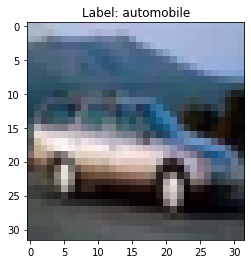

In [7]:
# Access the 5th element (index 4)
image, label_index = train_dataset[4]

# Convert the image tensor to a numpy array and transpose it to (H, W, C) format
image = image.numpy().transpose((1, 2, 0))

# Visualize the image
plt.imshow(image)
plt.title(f"Label: {CIFAR10_LABEL[label_index]}")
plt.show()

<image no.0>
torch.Size([3, 32, 32])
torch.Size([32, 32, 3])


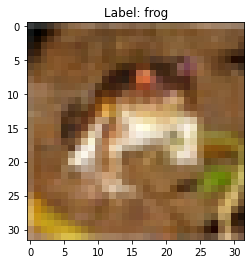

<image no.1>
torch.Size([3, 32, 32])
torch.Size([32, 32, 3])


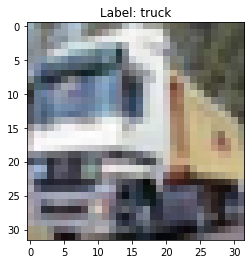

<image no.2>
torch.Size([3, 32, 32])
torch.Size([32, 32, 3])


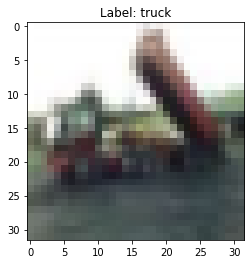

<image no.3>
torch.Size([3, 32, 32])
torch.Size([32, 32, 3])


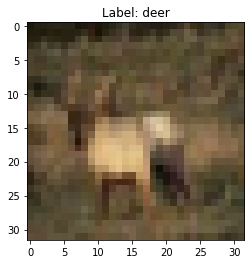

In [18]:
"""
(2) Convert the first 4 samples in the train_dataset to pytorch tensor and print their sizes and labels

-hint1: Use transforms.ToTensor() to convert image to pytorch tensor
-hint2: label information is given with CIFAR10_LABEL variable"""

import torchvision.transforms as transforms

fig = plt.figure()

for i in range(4):
    print(f"<image no.{i}>")
    image, label_idx = train_dataset[i]
    #print(image.shape) - not tensor yet
    image = transforms.ToTensor()(image)
    print(image.shape)
    image = image.permute((1, 2, 0))
    print(image.shape)
    plt.imshow(image)
    plt.title(f"Label: {CIFAR10_LABEL[label_idx]}")
    plt.show()

In [8]:
# Custom Dataset

class CustomDataset(Dataset):
    def __init__(self, train, transform=None, data_dir='./data/CIFAR_10'):
        self.data = datasets.CIFAR10(root=data_dir, train=train, download=True)
        self.transform = transform
    def __len__(self):
        return len(self.data)
    def __getitem__(self, idx):
        return self.data[idx]
    def collate_fn(self, data):
        batch_x, batch_y = [], []
        for x, y in data:
            if self.transform is not None:
                x = self.transform(x)
            x = transforms.ToTensor()(x)
            y = torch.Tensor([y])
            batch_x.append(X)
            batch_y.append(y)
        batch_x = torch.stack(batch_x).float()
        batch_y = torch.long(batch_y).long()
        return batch_x, batch_y
    

In [10]:
train_dataset = CustomDataset(train=True)
test_dataset = CustomDataset(train=False)

from torch.utils.data import DataLoader

BATCH_SIZE = 64
train_loader = DataLoader(dataset = train_dataset,
                          batch_size = BATCH_SIZE,
                          shuffle = True,
                          collate_fn = train_dataset.collate_fn)
test_loader = DataLoader(dataset = test_dataset,
                          batch_size = BATCH_SIZE,
                          shuffle = False,
                          collate_fn = test_dataset.collate_fn)

100%|██████████| 170498071/170498071 [02:11<00:00, 1295324.10it/s]


Extracting ./data/CIFAR_10/cifar-10-python.tar.gz to ./data/CIFAR_10
Files already downloaded and verified
